In [100]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
import pathlib

In [73]:
X_train, Y_train = loadlocal_mnist(
    images_path='train-images-idx3-ubyte', labels_path='train-labels-idx1-ubyte')
X_test, Y_test = loadlocal_mnist(
    images_path='t10k-images-idx3-ubyte', labels_path='t10k-labels-idx1-ubyte')

In [74]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

X_train: (60000, 784)
Y_train: (60000,)
X_test:  (10000, 784)
Y_test:  (10000,)


In [91]:
#separating data into target classes and storing indexes
citr = []
cite = []
for i in (1, 2):
    citr.append(np.argwhere(Y_train == i))
    cite.append(np.argwhere(Y_test == i))

citr = np.array(ci1)
cite = np.array(ci2)

### Separating trouser and pullover images/labels from other cloth types

In [92]:
X_train2 = X_train[np.append(citr[0], citr[1])]
X_test2 = X_test[np.append(cite[0], cite[1])]
Y_train2 = Y_train[np.append(citr[0], citr[1])]
Y_test2 = Y_test[np.append(cite[0], cite[1])]

In [93]:
ci = []
for i in (1, 2):
    ci.append(np.argwhere(Y_train2 == i))

### Binarizing data

In [102]:
def binarize(x):
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if(x[i][j] > 127):
                x[i][j] = 255
            else:
                x[i][j] = 0

if pathlib.Path('xtrain2.npy').exists():
    X_train2 = np.load('xtrain2.npy')
else:
    X_train2 = binarize(X_train2)
    np.save('xtrain2.npy', X_train2)

if pathlib.Path('xtest2.npy').exists():
    X_test2 = np.load('xtest2.npy')
else:
    X_test2 = binarize(X_test2)
    np.save('xtest2.npy', X_test2)

ValueError: Object arrays cannot be loaded when allow_pickle=False

### Displaying 5 images from our target classes, trouser and pullover (class 1 and class 2)

TypeError: 'NoneType' object is not subscriptable

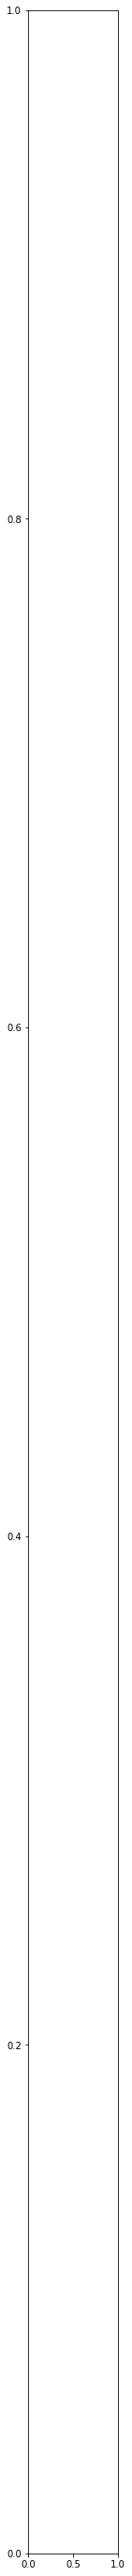

In [103]:
for i in (1, 2):
    plt.figure(figsize=(10, 50))
    count = 0
    for j in range(5):
        plt.subplot(1, 5, j+1)
        plt.imshow(X_train2[ci[i-1][j]].reshape(28, 28))
    plt.show()